In [1]:
import cv2
import mediapipe as mp
import numpy as np
import os
from glob import glob
import shutil

from scipy.interpolate import interp1d

In [2]:
device_dict={"S":"Smartphone", 
             "T":"Tablet",
             "L":"Laptop",
             "V":"VehicleLCD",
             "M":"Monitor"}
status_dict={"F":"Focus"}

In [3]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [47]:
flist = glob('/media/di/mx500_2tb2/NIA2022_2/0826/processing/S1/0??/T1/*/RGB/*.mp4')
#flist = glob("/media/di/data/NIA2022/0823/processing/S1/*/T1/*/RGB/*.mp4")
flist.sort()

In [66]:
factor = 360*10 # In fact, we need to take acount of focal length, pixel scale, and distortion

In [85]:
wdir

'/media/di/date/NIA2022/0825/processing/S1/'

PCN에 영상파일 이름 변경

In [91]:
nia_dir = "/run/user/1000/gvfs/sftp:host=pcndev.co.kr,port=10200/AIDATA/"
ddir1 = "/media/di/data/NIA2022/"

for date in [2,4,5,8,9,10,11,12,16,17,18,19,22,23,25][]:
    wdir = nia_dir+f'08{date:02d}/processing/S1/'

    flist = glob(wdir+"0??/T1/*/RGB/*_rgb_*.mp4")
    flist.sort()
    print(len(flist))
    # .mp4 파일명 수정
    # .csv도 필요하면 적용
    # mp4 먼저 고치고 나머지 처리하면 csv 파일 이름 변경할 필요 없음. 
    for fncsv in flist:
        fnew = fncsv.replace("_K_", "_T_")
        if fnew != fncsv:
            shutil.move(fncsv, fnew)

453


In [96]:
nia_dir = "/run/user/1000/gvfs/sftp:host=pcndev.co.kr,port=10200/AIDATA/"
ddir1 = "/media/di/data/NIA2022/"
ddir2 = "/media/di/mx500_2tb2/NIA2022_2"
for date in [2,4,5,8,9,10,11,12,16,17,18,19,22,23,25][3:-3]:
    wdir = ddir1+f'08{date:02d}/processing/S1/'

    flist = glob(wdir+"0??/T1/*/RGB/*_rgb_*.mp4")
    flist.sort()
    print(len(flist))
    # .mp4 파일명 수정
    # .csv도 필요하면 적용
    # mp4 먼저 고치고 나머지 처리하면 csv 파일 이름 변경할 필요 없음. 
    for fncsv in flist:
        fnew = fncsv.replace("_K_", "_T_")
        if fnew != fncsv:
            shutil.move(fncsv, fnew)
            
    # 수정된 이름으로 다시 
    flist = glob(wdir+"0??/T1/*/RGB/*_rgb_*.mp4")
    flist.sort()
    for iin, fn in enumerate(flist):
        out_dir = fn.split("NIA22EYE")[0]
        fn_ = fn.split("/")[-1]

        _, _, ID, _, scenario, device, imgtype, status, action, orientation = fn_.split("_")
        orientation = orientation.split(".mp4")[0]

        new_dir = out_dir.replace("RGB/", "FaceAngle/")

        if not os.path.isdir(new_dir):
            os.mkdir(new_dir)

        fn_out = fn_.replace("rgb", "head")
        fn_out = fn_out.replace(".mp4", ".csv")
        
        if os.path.getsize(new_dir+fn_out) > 40:
            print("pass")
            continue

        cap = cv2.VideoCapture(fn)    
        nframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        arr = np.zeros(nframes, dtype=[("roll", float), 
                                       ("pitch", float),
                                       ("yaw", float)])
        i = 0
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                break

            # Flip the image horizontally for a later selfie-view display
            # Also convert the color space from BGR to RGB
            image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)

            # To improve performance
            image.flags.writeable = False

            # Get the result
            results = face_mesh.process(image)

            # To improve performance
            image.flags.writeable = True

            # Convert the color space from RGB to BGR
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            img_h, img_w, img_c = image.shape
            face_3d = []
            face_2d = []

            if results.multi_face_landmarks:
                for face_landmarks in results.multi_face_landmarks:
                    for idx, lm in enumerate(face_landmarks.landmark):
                        if idx == 33 or idx == 263 or idx == 1 or idx == 61 or idx == 291 or idx == 199:
                            if idx == 1:
                                nose_2d = (lm.x * img_w, lm.y * img_h)
                                nose_3d = (lm.x * img_w, lm.y * img_h, lm.z * img_w)

                            x, y = int(lm.x * img_w), int(lm.y * img_h)

                            # Get the 2D Coordinates
                            face_2d.append([x, y])

                            # Get the 3D Coordinates
                            face_3d.append([x, y, lm.z])       

                    # Convert it to the NumPy array
                    face_2d = np.array(face_2d, dtype=np.float64)

                    # Convert it to the NumPy array
                    face_3d = np.array(face_3d, dtype=np.float64)

                    # The camera matrix
                    focal_length = 1 * img_w

                    cam_matrix = np.array([ [focal_length, 0, img_h / 2],
                                            [0, focal_length, img_w / 2],
                                            [0, 0, 1]])

                    # The Distortion Matrix
                    dist_matrix = np.zeros((4, 1), dtype=np.float64)

                    # Solve PnP
                    success, rot_vec, trans_vec = cv2.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)

                    # Get rotational matrix
                    rmat, jac = cv2.Rodrigues(rot_vec)

                    # Get angles
                    angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)
                    arr['roll'][i]  = angles[0]
                    arr['pitch'][i] = angles[1]
                    arr['yaw'][i]   = angles[2]

    #         if cv2.waitKey(2) & 0xFF == 27:
    #             break

            i+=1

        cap.release()

        # temp
        arr['roll'] -= np.mean(arr['roll'][5::100])
        arr['pitch'] -= np.mean(arr['pitch'][5::100])
        for field in ['roll', 'pitch', 'yaw']:
            ind = np.where(arr[field]!=0)[0]
            if len(ind) < 2:
                print("No valid points", len(ind))
                break
            elif len(ind) < len(arr):
                f = interp1d(ind, arr[field][ind])
                arr[field] = f(np.linspace(min(ind),max(ind), len(arr)))
                print("Interpolated")

        arr["roll"] *= factor
        arr["pitch"] *= factor
        arr["yaw"] *= factor


        with open(new_dir+fn_out, "w") as f:
            f.write("[head angle] roll      pitch      yaw\n")
            for roll, pitch, yaw in arr:
                f.write(f"{roll:.4f}, {pitch:.4f}, {yaw:.4f}\n")

        print(new_dir+fn_out, "done")

892
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
p

No valid points 0
/media/di/data/NIA2022/0809/processing/S1/012/T1/Tablet/FaceAngle/NIA22EYE_S1_012_T1_S10_T_head_A_C_L.csv done
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
444
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pa

[mjpeg @ 0x55cff4feb680] error dc
[mjpeg @ 0x55cff4feb680] error y=67 x=119
[mjpeg @ 0x55cff4feb680] error dc
[mjpeg @ 0x55cff4feb680] error y=67 x=119
[mjpeg @ 0x55cff4feb680] error dc
[mjpeg @ 0x55cff4feb680] error y=67 x=119
[mjpeg @ 0x55cff4feb680] error dc
[mjpeg @ 0x55cff4feb680] error y=67 x=119
[mjpeg @ 0x55cff4feb680] error dc
[mjpeg @ 0x55cff4feb680] error y=67 x=119
[mjpeg @ 0x55cff4feb680] error dc
[mjpeg @ 0x55cff4feb680] error y=67 x=119
[mjpeg @ 0x55cff4feb680] error dc
[mjpeg @ 0x55cff4feb680] error y=67 x=119
[mjpeg @ 0x55cff4feb680] error dc
[mjpeg @ 0x55cff4feb680] error y=67 x=119
[mjpeg @ 0x55cff4feb680] error dc
[mjpeg @ 0x55cff4feb680] error y=67 x=119
[mjpeg @ 0x55cff4feb680] error dc
[mjpeg @ 0x55cff4feb680] error y=67 x=119
[mjpeg @ 0x55cff4feb680] error dc
[mjpeg @ 0x55cff4feb680] error y=67 x=119
[mjpeg @ 0x55cff4feb680] error dc
[mjpeg @ 0x55cff4feb680] error y=67 x=119
[mjpeg @ 0x55cff4feb680] error dc
[mjpeg @ 0x55cff4feb680] error y=67 x=119
[mjpeg @ 0x5

No valid points 0
/media/di/data/NIA2022/0811/processing/S1/014/T1/Laptop/FaceAngle/NIA22EYE_S1_014_T1_S04_L_head_F_U_T.csv done
pass
pass
pass
pass
pass
pass
No valid points 0
/media/di/data/NIA2022/0811/processing/S1/014/T1/Laptop/FaceAngle/NIA22EYE_S1_014_T1_S04_L_head_S_D_T.csv done
No valid points 0
/media/di/data/NIA2022/0811/processing/S1/014/T1/Laptop/FaceAngle/NIA22EYE_S1_014_T1_S04_L_head_S_E_T.csv done
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
No valid points 0
/media/di/data/NIA2022/0811/processing/S1/014/T1/Laptop/FaceAngle/NIA22EYE_S1_014_T1_S05_L_head_F_C_T.csv done
pass
pass
pass
pass
No valid points 0
/media/di/data/NIA2022/0811/processing/S1/014/T1/Laptop/FaceAngle/NIA22EYE_S1_014_T1_S05_L_head_F_T_T.csv done
No valid points 0
/media/di/data/NIA2022/0811/processing/S1/014/T1/Laptop/FaceAngle/NIA22EYE_S1_014_T1_S05_L_head_F_U_T.csv done
pass
pass
pass
pass
pass
pass
pass
pass
pass
No valid points 0
/media/di/data/NIA2022/0811/processing/S1/0

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55cff8c87800] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55cff8c87800] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55cff8c87800] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55cff8c87800] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55cff8c87800] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55cff8c87800] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55cff8c87800] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55cff8c87800] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55cff8c87800] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55cff8c87800] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55cff8c87800] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55cff8c87800] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55cff8c87800] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55cff8c87800] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55cff8c87800] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55cff8c87800] moov atom no

No valid points 0
/media/di/data/NIA2022/0811/processing/S1/015/T1/Smartphone/FaceAngle/NIA22EYE_S1_015_T1_S10_S_head_A_C_T.csv done
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pa

No valid points 0
/media/di/data/NIA2022/0816/processing/S1/019/T1/Smartphone/FaceAngle/NIA22EYE_S1_019_T1_S08_S_head_F_F_T.csv done
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
No valid points 0
/media/di/data/NIA2022/0816/processing/S1/019/T1/Smartphone/FaceAngle/NIA22EYE_S1_019_T1_S10_S_head_S_F_T.csv done
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass

No valid points 0
/media/di/data/NIA2022/0818/processing/S1/022/T1/Smartphone/FaceAngle/NIA22EYE_S1_022_T1_S01_S_head_F_D_T.csv done
pass
pass
pass
pass
pass
pass
pass
pass
No valid points 0
/media/di/data/NIA2022/0818/processing/S1/022/T1/Smartphone/FaceAngle/NIA22EYE_S1_022_T1_S01_S_head_F_H_T.csv done
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
No valid points 0
/media/di/data/NIA2022/0818/processing/S1/022/T1/Tablet/FaceAngle/NIA22EYE_S1_022_T1_S01_T_head_D_C_R.csv done
pass
No valid points 0
/media/di/data/NIA2022/0818/processing/S1/022/T1/Tablet/FaceAngle/NIA22EYE_S1_022_T1_S01_T_head_D_D_L.csv done
No valid points 0
/media/di/data/NIA2022/0818/proce

No valid points 0
/media/di/data/NIA2022/0819/processing/S1/024/T1/Laptop/FaceAngle/NIA22EYE_S1_024_T1_S06_L_head_F_E_T.csv done
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
No valid points 0
/media/di/data/NIA2022/0819/processing/S1/024/T1/Smartphone/FaceAngle/NIA22EYE_S1_024_T1_S03_S_head_D_L_T.csv done
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
No valid points 0
/media/di/data/NIA2022/0819/processing/S1/024/T1/Smartphone/FaceAngle/NIA22EYE_S1_024_T1_S03_S_head_F_H_T.csv done
pass


In [68]:
import matplotlib.pyplot as plt

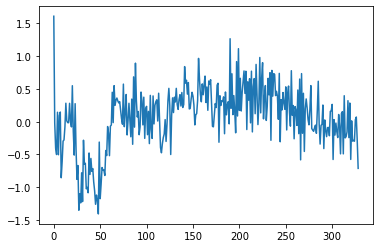

In [77]:
plt.plot(arr["pitch"])

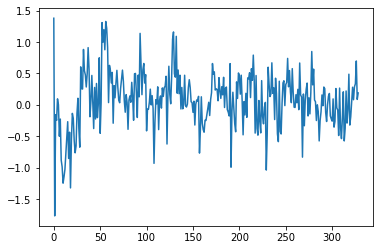

In [79]:
plt.plot(arr["roll"])

In [62]:
angles[0]

0.006632656066862159

In [61]:
angles[::50]

(0.006632656066862159,)

In [56]:
arr

array([(     0.        ,  0.        ,  0.        ),
       (-10071.79772791,  6.67169377, -0.03774351),
       (-10070.1904794 , 10.89713716, -0.04928554),
       (-10071.0005683 ,  9.0315223 , -0.05727826),
       (-10071.46677588,  9.94894582, -0.05627956),
       (-10071.32223493, 10.00615911, -0.05940076),
       (-10070.91965312,  9.66240262, -0.06084437),
       (-10071.18689619,  9.37573404, -0.05863604),
       (-10071.46118664,  9.58873419, -0.05611482),
       (-10071.13690606,  9.11821446, -0.05320366),
       (-10071.37039266,  9.23667817, -0.0592447 ),
       (-10071.15651171,  9.12292101, -0.05943971),
       (-10071.02154747,  9.276311  , -0.05397031),
       (-10071.35534544,  9.63914505, -0.06229168),
       (-10071.4846741 ,  9.45684561, -0.05508453),
       (-10071.57689532,  9.46732405, -0.05715691),
       (-10071.27094622,  9.72221899, -0.05718727),
       (-10071.05278459,  9.32413762, -0.05426967),
       (-10071.28196779,  9.7162201 , -0.0589706 ),
       (-100

In [55]:
f(np.arange(len(arr)))

ValueError: A value in x_new is below the interpolation range.

In [52]:
len(arr)

328